In [1]:
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from torch.nn import ReLU
import numpy as np
import torch
import random

from source.models import MLP
from source.trainer import Trainer

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# MNIST dataset

In [3]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
class BlackToPurpleTransform(object):
    def __call__(self, tensor):
        # Convert it to RGB by repeating the tensor three times along a new dimension
        x_rgb = torch.cat([tensor, tensor, tensor], dim=0)
        # Define purple color in normalized RGB
        purple = torch.tensor([128/255, 0, 128/255], device=tensor.device)
        # Mask where pixels are black
        black_mask = tensor[0] == 0
        # Apply purple color to black pixels
        x_rgb[:, black_mask] = purple[:, None]
        return x_rgb

In [5]:
class BlackToGrayTransform(object):
    def __call__(self, tensor):
        slight_gray = 128/255
        black_mask = tensor == 0
        tensor[black_mask] = slight_gray
        return tensor

In [6]:
class AddGaussianNoisePaddingTransform(object):
    def __init__(self, padding=10, mean=0.0, std=0.1):
        """
        Initialize the parameters for padding and Gaussian noise.
        
        Args:
        padding (int): The padding size to add to each border of the image.
        mean (float): The mean of the Gaussian noise.
        std (float): The standard deviation of the Gaussian noise.
        """
        self.padding = padding
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Create a new tensor with padding added and initial fill value 0
        padded_tensor = torch.zeros((tensor.size(0), tensor.size(1) + 2 * self.padding, tensor.size(2) + 2 * self.padding))
        # Place the original image in the center of the new tensor
        padded_tensor[:, self.padding:-self.padding, self.padding:-self.padding] = tensor
        # Generate Gaussian noise
        noise = torch.normal(mean=self.mean, std=self.std, size=padded_tensor.size())
        # Create a mask for the padding area (True where padding is)
        mask = torch.zeros(padded_tensor.size(), dtype=torch.bool)
        mask[:, self.padding:-self.padding, self.padding:-self.padding] = True
        # Invert the mask to apply noise only to the padding areas
        noise_mask = ~mask
        # Apply Gaussian noise only to the padding areas
        padded_tensor[noise_mask] = abs(noise[noise_mask])
        return padded_tensor

In [7]:
class AddGaussianNoisePaddingRGBTransform(object):
    def __init__(self, padding=10, mean=0.0, std=0.1):
        """
        Initialize the parameters for padding and Gaussian noise in RGB format.

        Args:
            padding (int): The padding size to add to each border of the image.
            mean (float): The mean of the Gaussian noise.
            std (float): The standard deviation of the Gaussian noise.
        """
        self.padding = padding
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Create a new tensor for RGB with padding added, initial fill value 0
        padded_tensor = torch.zeros((3, tensor.size(1) + 2 * self.padding, tensor.size(2) + 2 * self.padding))
        # Place the original image in the center of the new tensor
        padded_tensor[:, self.padding:-self.padding, self.padding:-self.padding] = tensor
        # Generate Gaussian noise for each RGB channel
        noise = torch.normal(self.mean, self.std, size=padded_tensor.size())
        # Create a mask for the padding area (False where padding is not)
        mask = torch.zeros(padded_tensor.size(), dtype=torch.bool)
        mask[:, self.padding:-self.padding, self.padding:-self.padding] = True
        # Invert the mask to apply noise only to the padding areas
        noise_mask = ~mask
        # Apply Gaussian noise only to the padding areas
        padded_tensor[noise_mask] = abs(noise[noise_mask])
        return padded_tensor

In [8]:
class AddGaussianNoiseTransform(object):
    def __init__(self, mean=0.0, std=0.1):
        """
        Initialize the parameters for Gaussian noise.
        
        Args:
        mean (float): The mean of the Gaussian noise.
        std (float): The standard deviation of the Gaussian noise.
        """
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Generate Gaussian noise
        noise = torch.normal(mean=self.mean, std=self.std, size=tensor.size())
        # Add noise to the entire image tensor
        noisy_tensor = tensor + noise
        return noisy_tensor

In [9]:
transform = transforms.Compose([transforms.ToTensor()])
transform_purple = transforms.Compose([transform, BlackToPurpleTransform()])
transform_grey = transforms.Compose([transform, BlackToGrayTransform()])
transform_gaussian = transforms.Compose([transform, AddGaussianNoisePaddingTransform()])
transform_gaussian_rgb = transforms.Compose([transform, AddGaussianNoisePaddingRGBTransform()])
transform_gaussian_all = transforms.Compose([transform, AddGaussianNoiseTransform()])

In [10]:
bs = 4096

# Fetch datasets.
train_data_normal = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_data_purple = datasets.MNIST(root='data', train=True, download=True, transform=transform_purple)
train_data_grey = datasets.MNIST(root='data', train=True, download=True, transform=transform_grey)
train_data_gaussian = datasets.MNIST(root='data', train=True, download=True, transform=transform_gaussian)
train_data_gaussian_rgb = datasets.MNIST(root='data', train=True, download=True, transform=transform_gaussian_rgb)
train_data_gaussian_all = datasets.MNIST(root='data', train=True, download=True, transform=transform_gaussian_all)

test_data_normal = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_data_purple = datasets.MNIST(root='data', train=False, download=True, transform=transform_purple)
test_data_grey = datasets.MNIST(root='data', train=False, download=True, transform=transform_grey)
test_data_gaussian = datasets.MNIST(root='data', train=False, download=True, transform=transform_gaussian)
test_data_gaussian_rgb = datasets.MNIST(root='data', train=False, download=True, transform=transform_gaussian_rgb)
test_data_gaussian_all = datasets.MNIST(root='data', train=False, download=True, transform=transform_gaussian_all)

# Create dataloaders.
train_loader_normal = DataLoader(train_data_normal, batch_size=bs, shuffle=False)
train_loader_purple = DataLoader(train_data_purple, batch_size=bs, shuffle=False)
train_loader_grey = DataLoader(train_data_grey, batch_size=bs, shuffle=False)
train_loader_gaussian = DataLoader(train_data_gaussian, batch_size=bs, shuffle=False)
train_loader_gaussian_rgb = DataLoader(train_data_gaussian_rgb, batch_size=bs, shuffle=False)
train_loader_gaussian_all = DataLoader(train_data_gaussian_all, batch_size=bs, shuffle=False)

test_loader_normal = DataLoader(test_data_normal, batch_size=bs, shuffle=False)
test_loader_purple = DataLoader(test_data_purple, batch_size=bs, shuffle=False)
test_loader_grey = DataLoader(test_data_grey, batch_size=bs, shuffle=False)
test_loader_gaussian = DataLoader(test_data_gaussian, batch_size=bs, shuffle=False)
test_loader_gaussian_rgb = DataLoader(test_data_gaussian_rgb, batch_size=bs, shuffle=False)
test_loader_gaussian_all = DataLoader(test_data_gaussian_all, batch_size=bs, shuffle=False)

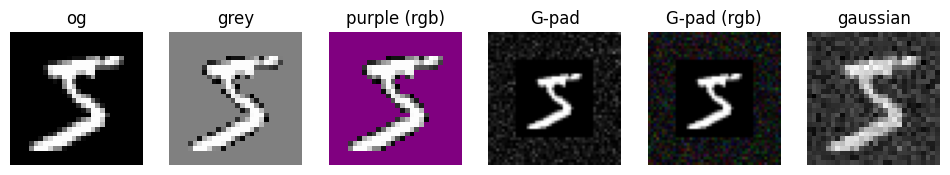

In [11]:
def plot_transformed_vs_original():
    # Create iterators for each data loader
    data_iter_normal = iter(train_loader_normal)
    data_iter_grey = iter(train_loader_grey)
    data_iter_purple = iter(train_loader_purple)
    data_iter_gaussian = iter(train_loader_gaussian)
    data_iter_gaussian_rgb = iter(train_loader_gaussian_rgb)
    data_iter_gaussian_all = iter(train_loader_gaussian_all)

    # Fetch one batch from each loader
    images_normal, _ = next(data_iter_normal)
    images_grey, _ = next(data_iter_grey)
    images_purple, _ = next(data_iter_purple)
    images_gaussian, _ = next(data_iter_gaussian)
    images_gaussian_rgb, _ = next(data_iter_gaussian_rgb)
    images_gaussian_all, _ = next(data_iter_gaussian_all)

    # Plot a single image from each type in a 1x4 grid
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 6, 1)
    plt.imshow(images_normal[0][0], cmap='gray')
    plt.title('og')
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(images_grey[0][0], cmap='gray')
    plt.title('grey')
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(images_purple[0].permute(1, 2, 0))  # For RGB images
    plt.title('purple (rgb)')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(images_gaussian[0][0], cmap='gray')
    plt.title('G-pad')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(images_gaussian_rgb[0].permute(1, 2, 0))  # For RGB images
    plt.title('G-pad (rgb)')
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(images_gaussian_all[0][0], cmap='gray')
    plt.title('gaussian')
    plt.axis('off')

    plt.show()

plot_transformed_vs_original()

# Base training

In [ ]:
loader = train_loader_gaussian_all
test_loader = test_loader_gaussian_all

# train with cross entropy

In [ ]:
import torch.nn as nn

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model
sample_input, _ = next(iter(loader))
input_size = sample_input.view(sample_input.size(0), -1).size(1)
model = MLP(input_size)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training loop
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data, target
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# Testing loop
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy}%')

# Run training and testing
train(model, loader, criterion, optimizer, epochs=20)
test(model, test_loader)

# train with mse 

In [11]:
bs = 32

# Fetch datasets.
train_data_gaussian_all = datasets.MNIST(root='data', train=True, download=True, transform=transform_gaussian_all)
test_data_gaussian_all = datasets.MNIST(root='data', train=False, download=True, transform=transform_gaussian_all)

# Create dataloaders.
loader = DataLoader(train_data_gaussian_all, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_data_gaussian_all, batch_size=bs, shuffle=False)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 784), # 512
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(784, 10)  # no logsoftmax
        )
        #self._initialize_weights()

    def forward(self, x):
        return self.layers(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)

# Helper function to convert labels to one-hot
def to_one_hot(labels, num_classes):
    return F.one_hot(labels, num_classes).float()

# Initialize model
sample_input, _ = next(iter(loader))
input_size = sample_input.view(sample_input.size(0), -1).size(1)
model = MLP(input_size)

# Loss and optimizer
criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Training loop
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data, to_one_hot(target, 10)  # Convert labels to one-hot vectors
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}', end='\r')

# Testing loop
def test(model, test_loader):
    model.eval()
    correct = 0
    total_loss = 0
    criterion = nn.MSELoss()  # Optionally compute loss in the test loop
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Optionally compute loss
            one_hot_target = to_one_hot(target, 10)  # Ensure target is one-hot for MSE
            loss = criterion(output, one_hot_target)
            total_loss += loss.item()

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy}%')
    print(f'Average Loss: {total_loss / len(test_loader)}')  # Optionally print average loss

# init.

In [12]:
W_init = model.layers[1].weight.detach().numpy()
eigenvalues_init, eigenvectors_init = np.linalg.eig(W_init)

# Might get some complex dust due to precision.
eigenvalues_init = np.real(eigenvalues_init)
eigenvectors_init = np.real(eigenvectors_init)

# analyze the weights with sgd-32

In [15]:
# Run training and testing
train(model, loader, criterion, optimizer, epochs=200)
test(model, test_loader)

Test Accuracy: 98.26%34845069117223223
Average Loss: 0.006280524538645443


In [16]:
W_sgd32 = model.layers[1].weight.detach().numpy()
eigenvalues_sgd32, eigenvectors_sgd32 = np.linalg.eig(W_sgd32)

# Might get some complex dust due to precision.
eigenvalues_sgd32 = np.real(eigenvalues_sgd32)
eigenvectors_sgd32 = np.real(eigenvectors_sgd32)

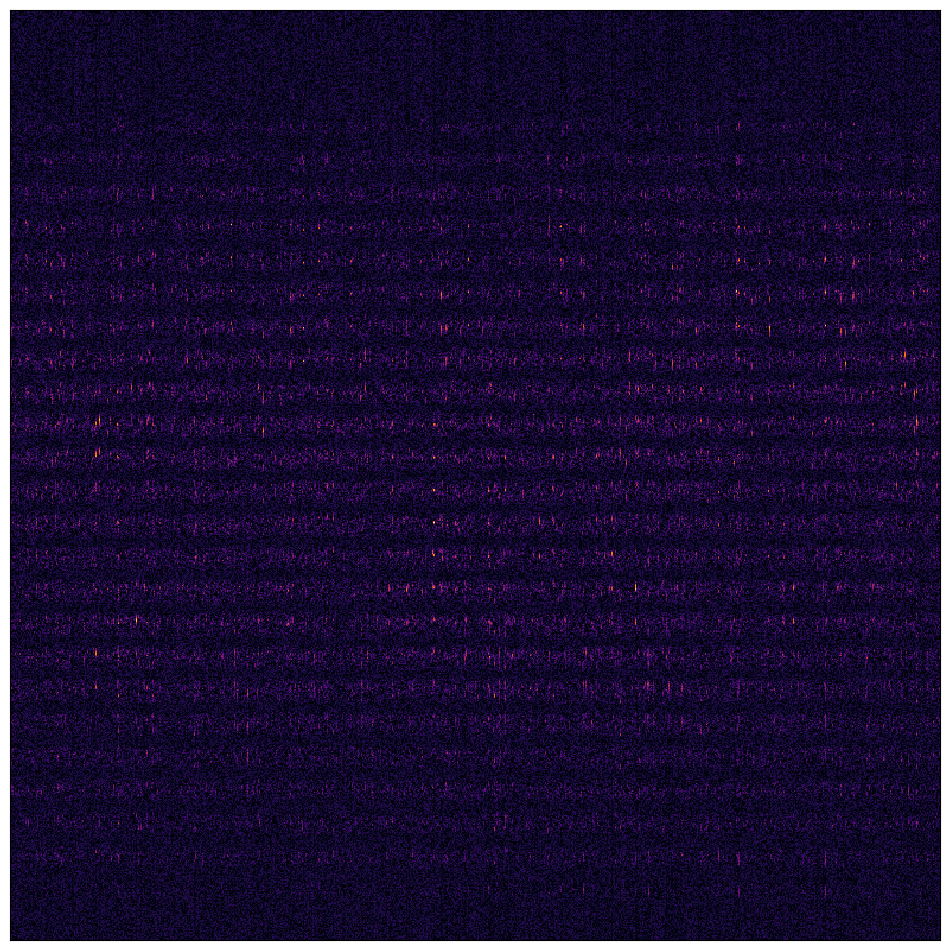

In [20]:
# first plot the weight as is
W_ = abs(W_sgd32)
vmin, vmax = W_.min(), W_.max()
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(W_.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
ax.set_xticks([]); ax.set_yticks([]);

# analyze the weights with sgd-8k

In [103]:
bs = 2048

# Fetch datasets.
train_data_gaussian_all = datasets.MNIST(root='data', train=True, download=True, transform=transform_gaussian_all)
test_data_gaussian_all = datasets.MNIST(root='data', train=False, download=True, transform=transform_gaussian_all)

# Create dataloaders.
loader = DataLoader(train_data_gaussian_all, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_data_gaussian_all, batch_size=bs, shuffle=False)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 784), # 512
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(784, 10)  # no logsoftmax
        )
        #self._initialize_weights()

    def forward(self, x):
        return self.layers(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)

# Helper function to convert labels to one-hot
def to_one_hot(labels, num_classes):
    return F.one_hot(labels, num_classes).float()

# Initialize model
sample_input, _ = next(iter(loader))
input_size = sample_input.view(sample_input.size(0), -1).size(1)
model = MLP(input_size)

# Loss and optimizer
criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Training loop
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data, to_one_hot(target, 10)  # Convert labels to one-hot vectors
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}', end='\r')

# Testing loop
def test(model, test_loader):
    model.eval()
    correct = 0
    total_loss = 0
    criterion = nn.MSELoss()  # Optionally compute loss in the test loop
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Optionally compute loss
            one_hot_target = to_one_hot(target, 10)  # Ensure target is one-hot for MSE
            loss = criterion(output, one_hot_target)
            total_loss += loss.item()

    accuracy = 100. * (correct / len(test_loader.dataset))
    loss = total_loss / len(test_loader)
    print(f'Test Accuracy: {accuracy:.2f}')
    print(f'Average Loss: {loss:.3f}')  # Optionally print average loss
    return loss, accuracy

In [108]:
# Run training and testing
train(model, loader, criterion, optimizer, epochs=1)
import sys
sys.stdout.flush()
test(model, test_loader)

Test Accuracy: 78.24788611287872
Average Loss: 0.053


(0.05335046574473381, 78.24)

In [105]:
_, acc = test(model, test_loader)

Test Accuracy: 65.80
Average Loss: 0.069


In [106]:
acc

65.8

In [37]:
W_sgd8k = model.layers[1].weight.detach().numpy()
eigenvalues_sgd8k, eigenvectors_sgd8k = np.linalg.eig(W_sgd8k)

# Might get some complex dust due to precision.
eigenvalues_sgd8k = np.real(eigenvalues_sgd8k)
eigenvectors_sgd8k = np.real(eigenvectors_sgd8k)

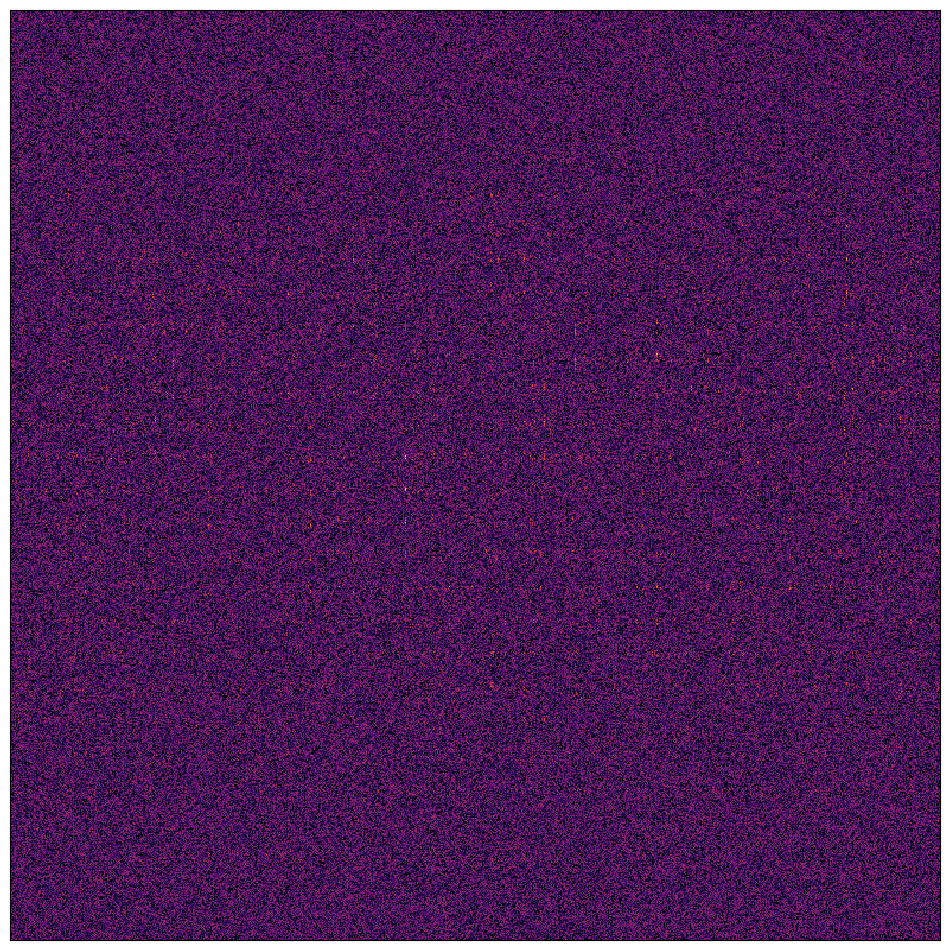

In [38]:
# first plot the weight as is
W_ = abs(W_sgd8k)
vmin, vmax = W_.min(), W_.max()
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(W_.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax)
ax.set_xticks([]); ax.set_yticks([]);

# plot the histograms together

Test Accuracy: 78.15
Average Loss: 0.053
Test Accuracy: 78.36
Average Loss: 0.053


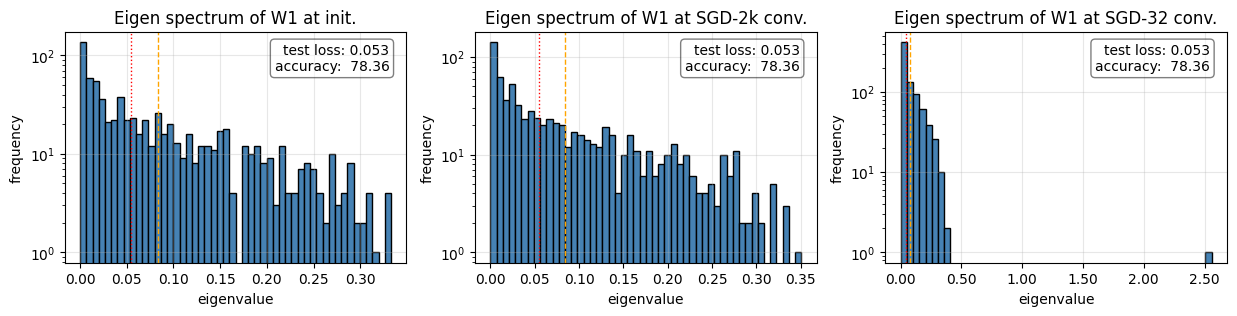

In [114]:
import matplotlib.ticker as ticker
locator = ticker.MaxNLocator(nbins=8)

mean_init = np.mean(eigenvalues_init**2)
median_init = np.median(eigenvalues_init**2)
mean_sgd8k = np.mean(eigenvalues_sgd8k**2)
median_sgd8k = np.median(eigenvalues_sgd8k**2)
mean_sgd32 = np.mean(eigenvalues_sgd32**2)
median_sgd32 = np.median(eigenvalues_sgd32**2)

# get accuracies
sgd_large_loss, sgd_large_acc = test(model, test_loader)
sgd_large_loss, sgd_large_acc = test(model, test_loader)

# same with histograms of spectrum.
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.hist(eigenvalues_init**2, bins=50, color='steelblue', edgecolor='black')
plt.axvline(mean_init, color='orange', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(median_init, color='red', linestyle='dotted', linewidth=1, label='median')
plt.title('Eigen spectrum of W1 at init.')
plt.xlabel('eigenvalue')
plt.ylabel('frequency')
plt.grid(alpha=0.3)
plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0, 450)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
textstr = f'test loss: {sgd_large_loss:.3f}\naccuracy:  {sgd_large_acc:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(
    0.95, 0.95, textstr, transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=props
)


plt.subplot(1, 3, 2)
plt.hist(eigenvalues_sgd8k**2, bins=50, color='steelblue', edgecolor='black')
plt.axvline(mean_sgd8k, color='orange', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(median_sgd8k, color='red', linestyle='dotted', linewidth=1, label='median')
plt.title('Eigen spectrum of W1 at SGD-2k conv.')
plt.xlabel('eigenvalue')
plt.ylabel('frequency')
plt.grid(alpha=0.3)
plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0, 450)
#plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
textstr = f'test loss: {sgd_large_loss:.3f}\naccuracy:  {sgd_large_acc:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(
    0.95, 0.95, textstr, transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=props
)


plt.subplot(1, 3, 3)
plt.hist(eigenvalues_sgd32**2, bins=50, color='steelblue', edgecolor='black')
plt.axvline(mean_sgd32, color='orange', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(median_sgd32, color='red', linestyle='dotted', linewidth=1, label='median')
plt.title('Eigen spectrum of W1 at SGD-32 conv.')
plt.xlabel('eigenvalue')
plt.ylabel('frequency')
plt.grid(alpha=0.3)
plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0, 450)
#plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
textstr = f'test loss: {sgd_large_loss:.3f}\naccuracy:  {sgd_large_acc:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(
    0.95, 0.95, textstr, transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=props
)

plt.show();

In [53]:
eigenvalues_sgd32[eigenvalues_sgd32 < -1]

array([-1.5992954], dtype=float32)

In [54]:
eigenvectors_sgd32[0].shape

(784,)

In [59]:
# Order the eigenvalues by their abs-magnitude.
sorted_indices_sgd32 = np.argsort(abs(eigenvalues_sgd32))[::-1]
sorted_eigenvalues_sgd32 = eigenvalues_sgd32[sorted_indices_sgd32]
sorted_eigenvectors_sgd32 = eigenvectors_sgd32[:, sorted_indices_sgd32]

In [60]:
sorted_eigenvalues_sgd32

array([-1.59929538e+00, -6.21714473e-01, -6.21714473e-01, -5.91787994e-01,
       -5.91787994e-01,  5.80381930e-01, -5.71592927e-01, -5.71592927e-01,
        5.68285525e-01,  5.68285525e-01, -5.62103868e-01,  5.61903954e-01,
        5.61903954e-01,  5.52051783e-01, -5.51964164e-01, -5.49663305e-01,
       -5.49663305e-01,  5.48602641e-01,  5.48602641e-01,  5.47599614e-01,
        5.47599614e-01, -5.47518671e-01, -5.47518671e-01,  5.35642087e-01,
        5.35642087e-01, -5.29779136e-01, -5.29779136e-01,  5.25754392e-01,
        5.25754392e-01, -5.24047852e-01, -5.24047852e-01,  5.19936442e-01,
        5.19936442e-01, -5.18817186e-01, -5.18817186e-01, -5.18306494e-01,
       -5.18306494e-01,  5.16103089e-01,  5.16103089e-01,  5.00839531e-01,
        5.00839531e-01, -4.99404281e-01, -4.99404281e-01,  4.99332815e-01,
        4.99332815e-01, -4.96654660e-01, -4.96654660e-01,  4.94690895e-01,
        4.94690895e-01,  4.94079381e-01,  4.94079381e-01, -4.91050333e-01,
       -4.91050333e-01,  

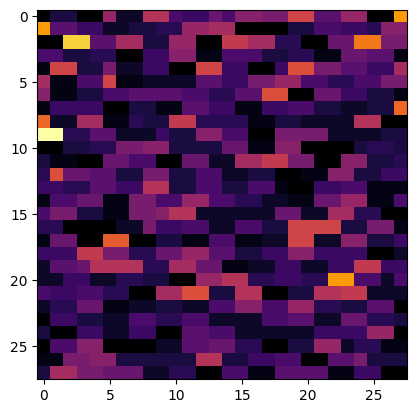

In [76]:
to_img = lambda x: transforms.ToPILImage()(torch.tensor(x).view(28, 28))
plt.imshow(to_img(abs(sorted_eigenvectors_sgd32[0])), cmap='inferno');

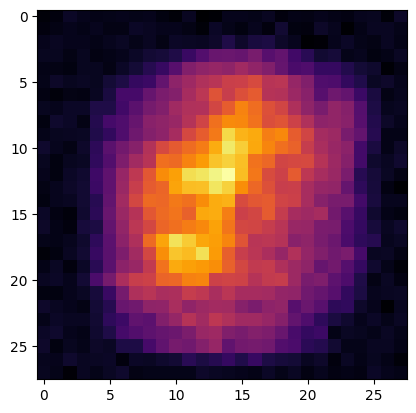

In [77]:
focusmap = np.linalg.norm(W_sgd32.T, axis=1)
focusmap = focusmap.reshape(28, 28)
vmin, vmax = focusmap.min(), focusmap.max()
plt.imshow(focusmap, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax);

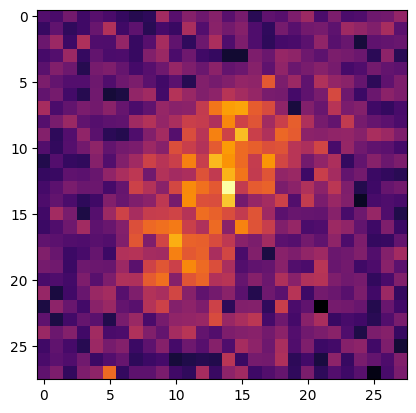

In [78]:
focusmap = np.linalg.norm(W_sgd8k.T, axis=1)
focusmap = focusmap.reshape(28, 28)
vmin, vmax = focusmap.min(), focusmap.max()
plt.imshow(focusmap, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax);

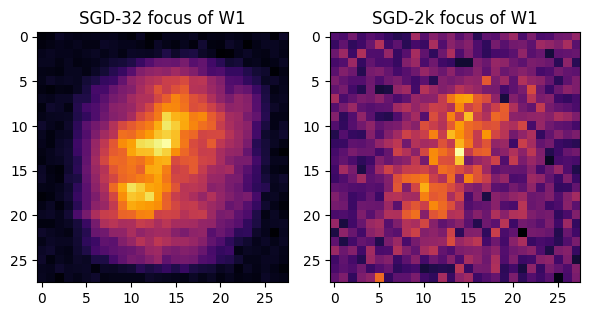

In [81]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

# Plot the first focusmap
focusmap1 = np.linalg.norm(W_sgd32.T, axis=1)
focusmap1 = focusmap1.reshape(28, 28)
vmin1, vmax1 = focusmap1.min(), focusmap1.max()
ax[0].imshow(focusmap1, cmap='inferno', interpolation='nearest', vmin=vmin1, vmax=vmax1)
ax[0].set_title('SGD-32 focus of W1')

# Plot the second focusmap
focusmap2 = np.linalg.norm(W_sgd8k.T, axis=1)
focusmap2 = focusmap2.reshape(28, 28)
vmin2, vmax2 = focusmap2.min(), focusmap2.max()
ax[1].imshow(focusmap2, cmap='inferno', interpolation='nearest', vmin=vmin2, vmax=vmax2)
ax[1].set_title('SGD-2k focus of W1')

# Show the plots
plt.tight_layout()
plt.show()

# more plotting

In [ ]:
lw, lh = 28, 28
i = 4

Wa = W_[:, :i*lw]
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(Wa.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax) 
ax.set_xticks([]); ax.set_yticks([]);

In [ ]:
Wb = W_[:, i*lw : -i*lw]
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(Wb.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax) 
ax.set_xticks([]); ax.set_yticks([]);

In [ ]:
Wc = W_[:, -i*lw:]
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(Wc.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax) 
ax.set_xticks([]); ax.set_yticks([]);

In [ ]:
Wd = W_[-128:, 12*lw:13*lw]
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(Wd.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax) 
ax.set_xticks([]); ax.set_yticks([]);

In [ ]:
vals = []
for i in range(784):
    vals.append(np.linalg.norm(W[:,i]))
plt.plot(vals)

# perform svd decomposition of mnist

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np

k = 60000 * 0.2
transform = transforms.Compose([transforms.ToTensor()])
flatten = transforms.Lambda(lambda x: x.flatten())
to_img = lambda x: transforms.ToPILImage()(x.view(28, 28))

trainset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
X = torch.stack([x.flatten() for idx, (x, _) in enumerate(trainset) if idx < k])

# SVD decomposition.
U, S, Vh = np.linalg.svd(X)
print(U.shape)
print(np.diag(S).shape)
print(Vh.shape)

In [ ]:
plt.imshow(to_img(X[0]), cmap='gray') # show the first image

In [ ]:
cov = X.T@X
plt.imshow(cov, cmap='gray');

In [ ]:
r = 1

# Approximation matrix.
Ur = U[:, :r]
Sr = np.diag(S[:r])
Vtr = Vh[:r, :]

# Reconstruction matrix.
Xhat = torch.tensor(Ur @ Sr @ Vtr)
plt.imshow(to_img(Xhat[0]), cmap='gray');

In [ ]:
# Reshuffled projection matrix.
Xproj = torch.tensor(Vh)@X[0]
plt.imshow(to_img(Xproj), cmap='gray');

In [ ]:
plt.plot(S[:50]);

In [ ]:
from kneed import KneeLocator
knee_locator = KneeLocator(range(len(S)), S, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee

# project weight layer in nice svd basis

In [ ]:
W_ = abs(W @ Vh.T)
vmin, vmax = W_.min(), W_.max()
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(W_.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax) 
ax.set_xticks([]); ax.set_yticks([]);

In [ ]:
vals = []
for i in range(784):
    vals.append(np.linalg.norm(W_[:,i]))
plt.plot(vals[:50]);

# where does the model look at?

In [ ]:
focusmap = np.linalg.norm(W.T, axis=1)
focusmap = focusmap.reshape(28, 28)

vmin, vmax = focusmap.min(), focusmap.max()
plt.imshow(focusmap, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax);

In [ ]:
# superpose 5 examples of mnist with the focusmap
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(to_img(X[i]), cmap='gray')
    ax[i].imshow(focusmap, cmap='inferno', interpolation='nearest', alpha=0.4, vmin=vmin, vmax=vmax)

In [ ]:
focusmap_svd = np.linalg.norm((W @ Vh.T).T, axis=1)
focusmap_svd = focusmap_svd.reshape(28, 28)

vmin, vmax = focusmap_svd.min(), focusmap_svd.max()
plt.imshow(focusmap_svd, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax);

In [ ]:
# superpose 5 examples of mnist with the svd focusmap
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(to_img(X[i] @ Vh.T), cmap='gray')
    ax[i].imshow(focusmap_svd, cmap='inferno', interpolation='nearest', alpha=0.4, vmin=vmin, vmax=vmax)

# quickly try the pruning hypothesis

In [ ]:
import torch.nn.utils.prune as prune

def prune_model(model, perc):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=perc)
            prune.remove(module, 'weight')  # Optional: makes the pruning permanent

print(model)

print("\nBefore pruning:")
for name, param in model.named_parameters():
    if 'weight' in name:
        print(name, param.nelement(), 'total elements,', param.numel() - param.nonzero().size(0), 'zero elements')

perc = 0.5
prune_model(model, perc)

print("\nAfter pruning:")
for name, param in model.named_parameters():
    if 'weight' in name:
        print(name, param.nelement(), 'total elements,', param.numel() - param.nonzero().size(0), 'zero elements')

warning: this is not doing pruning at all layers with same rate. but perc at every layer.

# check what we get if we train with projected svd directly ;)

In [ ]:
# get init mnist data.
n = len(train_data_grey)
img_shape = train_data_grey[0][0].shape

# transform to get ready for svd
X = torch.stack([train_data_grey[i][0].flatten() for i in range(n)])
y = [train_data_grey[i][1] for i in range(n)]

print(X.shape)
print(len(y))

In [ ]:
# make sure we're ok
plt.imshow(to_img(X[0]), cmap='gray') # show the first image

In [ ]:
# Shuffle the components based on SVD.
Xsvd_ = X @ Vh.T
print(Xsvd_.shape)

In [ ]:
# make sure we're ok
plt.imshow(to_img(Xsvd_[0]), cmap='gray') # show the first image

In [ ]:
# SVD transformed data.
Xsvd = torch.stack([Xsvd_[i].reshape(img_shape) for i in range(n)])
train_data_svd = TensorDataset(Xsvd, torch.tensor(y))
train_loader_svd = DataLoader(train_data_svd, batch_size=bs, shuffle=False)

In [ ]:
# Initialize model
sample_input, _ = next(iter(loader))
input_size = sample_input.view(sample_input.size(0), -1).size(1)
model = MLP(input_size)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train with transformed data.
train(model, train_loader_svd, criterion, optimizer, epochs=5)

In [ ]:
W = model.layers[1].weight.detach().numpy()
# first plot the weight as is
W_ = abs(W)
vmin, vmax = W_.min(), W_.max()
fig, ax = plt.subplots(figsize=(12, 40))
im1 = ax.imshow(W_.T, cmap='inferno', interpolation='nearest', vmin=vmin, vmax=vmax) 
ax.set_xticks([]); ax.set_yticks([]);

# drafts

In [ ]:
# Data exploration.
import torch.nn as nn
x1 = next(iter(loader))[0]
x1[0][0][0,0] = 1
x1[0][0][0,1] = 2
x1[0][0][1,0] = 3
x1f = nn.Flatten()(x1)
x1[0][0].shape
r1 = x1[0][0][0]
c1 = x1[0][0][:,0]

print("row1", r1)
print("col1", c1)
x1f[0][:28]
train_data_normal[0][1]